# Eating out in Lyon - Data analysis

## Summary

This is the second part of a data analysis project focused on finding a delicious pizza in my hometown of Lyon.
After gathering and cleaning data in the first part, I now focus on data analysis.
In the exploratory data analysis, I focus mainly on the mean price and ratings of restaurants across city districts and restaurant categories. I then go looking for outstanding restaurants — _i.e._, restaurants with a higher rating than restaurants of the same category and district — using the residuals of a linear model.

## Findings

Restaurant properties vary by city district:
- The historical center (Lyon 1 and 2) has the most restaurants, as well as the most reviews, which makes sense given its touristic appeal.
- Restaurants in fancy neighborhoods (Lyon 5 and 6) are the most expensive on average, but this is not reflected by higher ratings.
- Restaurants have better ratings on average in Lyon 7.


Here are the best pizzerias by district as identified through their residuals:

<img src="best_pizza.png" title="Best pizza places by district" width="700"/>


    
## Analysis

Let's first import some libraries and take a look at the data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('data/restaurants.csv')

In [2]:
data[data.columns[:8]].head()

,id,alias,name,review_count,rating,price,coordinates.latitude,coordinates.longitude
0,D3NHTerar80aeR6mlyE2mw,azur-afghan-lyon,Azur Afghan,23,4.0,€€,45.775020,4.828750
1,ee4wtKIBI_yTz0fJD054pg,tendance-afghane-lyon,Tendance Afghane,1,3.0,NaN,45.759540,4.825560
2,zmk41IUwIkvO_eM0UGD7Sg,sufy-lyon,Sufy,2,3.5,NaN,45.752212,4.864384
3,Vo0U5EcXbh7qlpdaQwZchA,le-conakry-lyon,Le Conakry,9,4.0,€€,45.750642,4.849127
4,-mFHJBuCxZJ_wJrO-o2Ypw,afc-africa-food-concept-lyon,AFC Africa Food Concept,8,3.5,€€,45.754336,4.843469


In [3]:
data[data.columns[8:]].head()

,location.address1,location.address2,location.address3,location.zip_code,location.country,location.display_address
0,6 Rue Villeneuve,NaN,NaN,69004,FR,"['6 Rue Villeneuve', '69004 Lyon', 'France']"
1,25 Rue Tramassac,NaN,NaN,69005,FR,"['25 Rue Tramassac', '69005 Lyon', 'France']"
2,34 rue Jeanne Hachette,NaN,NaN,69003,FR,"['34 rue Jeanne Hachette', '69003 Lyon', 'Fran..."
3,112 Grande rue de la Guillotière,NaN,NaN,69007,FR,"['112 Grande rue de la Guillotière', '69007 Ly..."
4,14 Grande rue de la Guillotière,NaN,NaN,69007,FR,"['14 Grande rue de la Guillotière', '69007 Lyo..."


### Review count and ratings distribution

Let's take a look at the review count and ratings distributions:

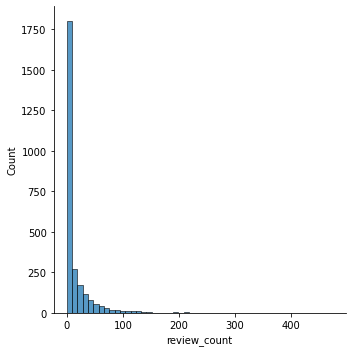

In [4]:
sns.displot(data = data, x = "review_count", bins = 50);

In [5]:
data['price_num'] = data['price'].map({'€': 1, '€€': 2, '€€€': 3, '€€€€': 4})

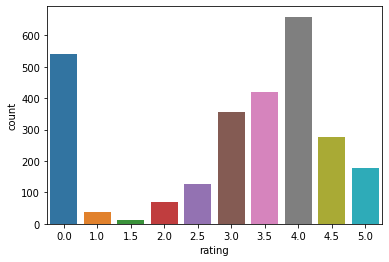

In [6]:
sns.countplot(data = data, x = "rating");

The ratings are strongly bimodal, with the bulk of the distribution centered around 4 but also numerous restaurants rated 0 stars.
The review counts are exponentially distributed, meaning that a large part of the restaurants have very few reviews.
Because ratings with few reviews might not be very informative, let's get rid of all restaurants with less than 10 reviews:

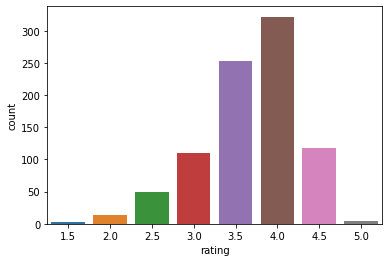

In [7]:
data = data[data['review_count'] >= 10]
sns.countplot(data = data, x = "rating");

Interestingly, all ratings of 0 or 1 star only applied to restaurants with few ratings, so we now have an unimodal ratings' distribution.

### Restaurants properties by districts

Let's now take a look at how variables of interest differ between districts.
Using geopandas, I'll look at the number of restaurants, mean rating, mean price and median number of reviews by district.

In [8]:
# importing spatial libraries
import geopandas
import geodatasets
import contextily as cx
from shapely.geometry import Point

In [9]:
# importing a geojson file describing the cities district as a geo-dataframe called 'lyon_map'
# obtained from https://data.grandlyon.com/jeux-de-donnees/arrondissements-lyon/info
lyon_map = geopandas.read_file('data/adr_voie_lieu.adrarrond.geojson')

# adding zip codes to be able to merge with the data
lyon_map['location.zip_code'] = lyon_map['nomreduit'].apply(lambda x:('6900' + x[-1])).astype('int')
lyon_map

,nom,nomreduit,insee,datemaj,trigramme,gid,geometry,location.zip_code
0,Lyon 1er Arrondissement,Lyon 1,69381,1997-10-22 00:00:00+00:00,LY1,128,"POLYGON ((4.83049 45.76454, 4.83125 45.76484, ...",69001
1,Lyon 9e Arrondissement,Lyon 9,69389,2005-07-19 00:00:00+00:00,LY9,181,"POLYGON ((4.81088 45.78099, 4.81145 45.78177, ...",69009
2,Lyon 2e Arrondissement,Lyon 2,69382,1997-10-22 00:00:00+00:00,LY2,59,"POLYGON ((4.81782 45.72649, 4.81868 45.72660, ...",69002
3,Lyon 4e Arrondissement,Lyon 4,69384,2003-05-12 00:00:00+00:00,LY4,29,"POLYGON ((4.81856 45.78944, 4.81817 45.78914, ...",69004
4,Lyon 3e Arrondissement,Lyon 3,69383,2005-07-19 00:00:00+00:00,LY3,125,"POLYGON ((4.83901 45.75660, 4.83956 45.75643, ...",69003
5,Lyon 5e Arrondissement,Lyon 5,69385,2005-07-19 00:00:00+00:00,LY5,53,"POLYGON ((4.81353 45.74819, 4.81357 45.74823, ...",69005
6,Lyon 7e Arrondissement,Lyon 7,69387,2000-03-30 00:00:00+00:00,LY7,189,"POLYGON ((4.83770 45.70737, 4.83894 45.70763, ...",69007
7,Lyon 8e Arrondissement,Lyon 8,69388,2011-03-03 00:00:00+00:00,LY8,42,"POLYGON ((4.84879 45.71885, 4.84881 45.71879, ...",69008
8,Lyon 6e Arrondissement,Lyon 6,69386,2005-07-19 00:00:00+00:00,LY6,45,"POLYGON ((4.86994 45.76373, 4.86986 45.76384, ...",69006


To obtain data by district, I group the restaurant data by 'location.zip_code' before merging it with the geodataframe 'lyon_map':

In [10]:

# merging lyon_map with the data aggregated by zip code to get mean and median rating, price and review counts:
lyon_map = lyon_map.merge(
                data.groupby('location.zip_code')[['review_count', 'rating', 'price_num']].agg([np.mean, np.median]),
                on = 'location.zip_code',
                how = 'left')

# merging lyon_map with the data aggregated by zip code to get the restaurant count by district:
lyon_map = lyon_map.merge(
                data.groupby('location.zip_code')['id'].count().reset_index(name="restaurants_count"),
                on = 'location.zip_code',
                how = 'left')

/home/camille/.local/lib/python3.8/site-packages/geopandas/geodataframe.py:1569: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  result = DataFrame.merge(self, *args, **kwargs)


I finally plot the variables of interest aggregated by district:

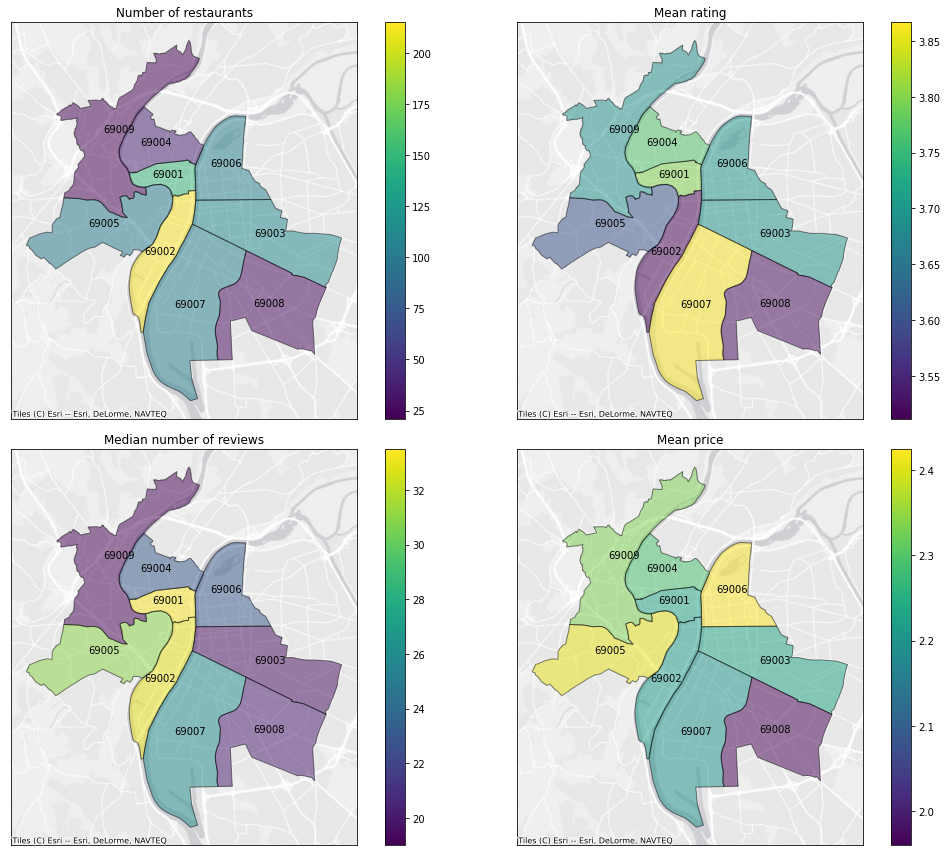

In [11]:
# changing the coordinates reference system to a more visually appealing one:
lyon_map = lyon_map.to_crs(epsg = 3857)

fig, ax = plt.subplots(2, 2, figsize = (15, 12))

# plotting number of restaurants
lyon_map.plot(ax = ax[0, 0], alpha = 0.5, edgecolor = "k", column = 'restaurants_count', legend = True)
lyon_map.apply(lambda x: ax[0, 0].annotate(text=x['location.zip_code'],
                                     xy=x.geometry.centroid.coords[0],
                                     ha='center'), axis=1)
cx.add_basemap(ax[0, 0], zoom = 12, source = cx.providers.Esri.WorldGrayCanvas)
ax[0, 0].set_title('Number of restaurants')


# plotting mean rating
lyon_map.plot(ax = ax[0, 1],alpha = 0.5, edgecolor = "k",
                   column = ('rating', 'mean'), legend = True)
lyon_map.apply(lambda x: ax[0, 1].annotate(text=x['location.zip_code'],
                                     xy=x.geometry.centroid.coords[0],
                                     ha='center'), axis=1)
cx.add_basemap(ax[0, 1], zoom = 12, source = cx.providers.Esri.WorldGrayCanvas)
ax[0, 1].set_title('Mean rating')

# plotting median review count
lyon_map.plot(ax = ax[1, 0], alpha = 0.5, edgecolor = "k", column = ('review_count', 'median'), legend = True)
lyon_map.apply(lambda x: ax[1, 0].annotate(text=x['location.zip_code'],
                                     xy=x.geometry.centroid.coords[0],
                                     ha='center'), axis=1)
cx.add_basemap(ax[1, 0], zoom = 12, source = cx.providers.Esri.WorldGrayCanvas)
ax[1, 0].set_title('Median number of reviews')

# plotting mean price
lyon_map.plot(ax = ax[1, 1], alpha = 0.5, edgecolor = "k", column = ('price_num', 'mean'), legend = True)
lyon_map.apply(lambda x: ax[1, 1].annotate(text=x['location.zip_code'],
                                     xy=x.geometry.centroid.coords[0],
                                     ha='center'), axis=1)
cx.add_basemap(ax[1, 1], zoom = 12, source = cx.providers.Esri.WorldGrayCanvas)
ax[1, 1].set_title('Mean price')

# removing ticks for better visibility
for k in [0, 1]:
    for l in [0, 1]:
        ax[k, l].set_xticks([])
        ax[l, k].set_yticks([])
        
fig.tight_layout()

- The historical center (Lyon 1 and 2) has the most restaurants, as well as the most reviews, which makes sense given its touristic appeal.
- Restaurants in fancy neighborhoods (Lyon 5 and 6) are the most expensive on average, but this is not reflected by higher ratings.
- Restaurants have better ratings on average in Lyon 7, but this effect is rather small.

### Restaurants properties by category

Let us now take a look at how categories affect the restaurant properties.

In [12]:
# Loading the dataframe of categories
categories_df = pd.read_csv('data/categories.csv')

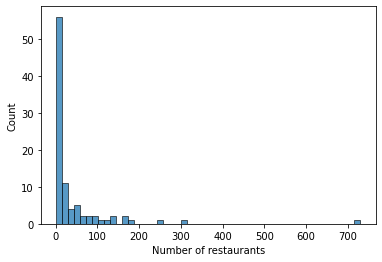

In [13]:
# taking a look at the distribution of the number of restaurant by category.
ax = sns.histplot(categories_df.drop('id', axis = 1).sum())
ax.set_xlabel('Number of restaurants');

Most categories contain very few restaurants, and are therefore not very informative. For the remainder of the analysis, I chose to keep only the most frequent categories.

In [14]:
## dropping all categories concerning less than 100 restaurants
sorted_categories = categories_df.drop('id', axis = 1).sum().sort_values(ascending = False)
# saving a vector of the top categories
top_categories = sorted_categories[sorted_categories >= 100]
# and a vector of all other categories to filter categories_df
non_top_categories = sorted_categories[sorted_categories < 100]

In [15]:
# dropping rare categories
categories_df.drop(non_top_categories.index, axis = 1, inplace = True)

To check how our variables of interest depend on categories, I create a dataframe of with the name of the most common categories, and then compute the restaurant count, mean rating and price and median review count for each category.

In [16]:
# creating a dataframe of the most frequent categories ('alias') and the number of categories for each ('count')
top_categories = pd.DataFrame(top_categories)
top_categories.reset_index(inplace = True)
top_categories.columns = ['alias', 'count']

In [17]:
# computing the mean rating by category
top_categories["mean_rating"] = top_categories['alias'].apply(lambda x: data['rating'][categories_df[x] > 0].mean())

# computing the median number of reviews
top_categories["median_reviews"] = top_categories['alias'].apply(lambda x: data['review_count'][categories_df[x] > 0].median())

# computing the mean price
top_categories["mean_price"] = top_categories['alias'].apply(lambda x: data['price_num'][categories_df[x] > 0].mean())

# taking a look at the resulting dataset:
top_categories

,alias,count,mean_rating,median_reviews,mean_price
0,french,730.0,3.747368,30.0,2.553571
1,hotdogs,308.0,3.366667,19.0,1.750000
2,pizza,255.0,3.561404,20.0,2.017544
3,italian,174.0,3.571429,20.5,2.115942
4,sandwiches,164.0,3.557692,20.0,1.576923
5,cafes,159.0,3.833333,30.0,1.974359
6,bistros,139.0,3.957143,24.0,2.314286
7,brasseries,134.0,3.346154,28.0,2.435897
8,burgers,123.0,3.337209,34.0,1.906977
9,japanese,113.0,3.661017,31.0,2.237288


Finally, let's take a look at the differences between categories in the form of bar charts:

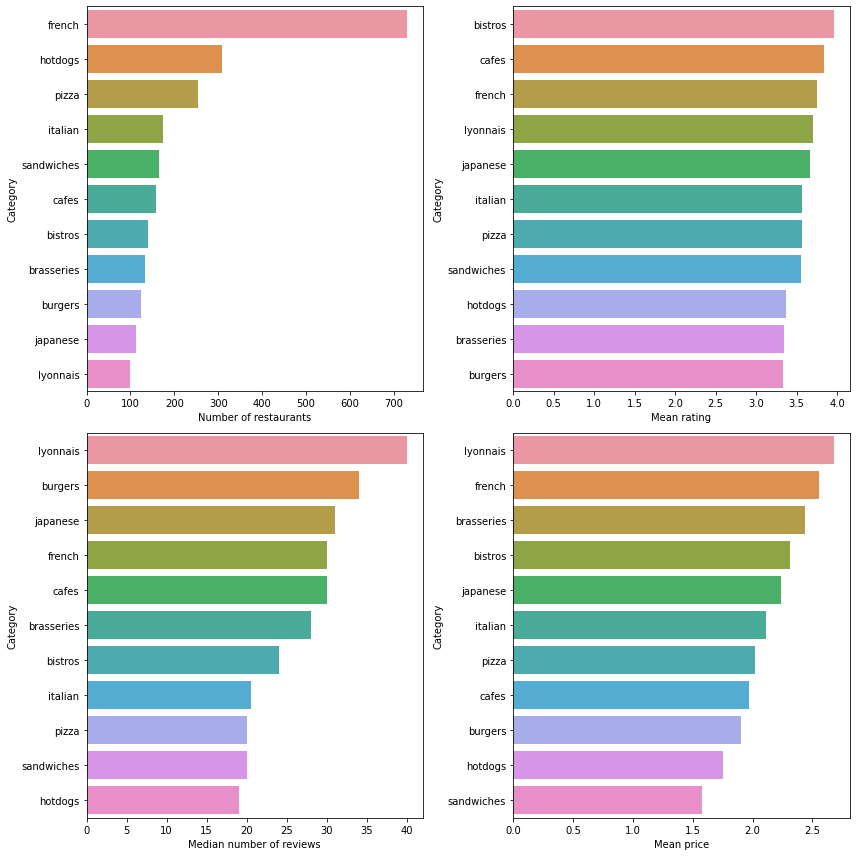

In [18]:
fig, ax = plt.subplots(2, 2, figsize = (12, 12))

sns.barplot(ax = ax[0, 0], data = top_categories, x = 'count', y = 'alias')
ax[0, 0].set_xlabel('Number of restaurants')
ax[0, 0].set_ylabel('Category')

sns.barplot(ax = ax[0, 1], data = top_categories, x = 'mean_rating', y = 'alias',
            order = top_categories.sort_values('mean_rating', ascending = False).alias)
ax[0, 1].set_xlabel('Mean rating')
ax[0, 1].set_ylabel('Category')

sns.barplot(ax = ax[1, 0], data = top_categories, x = 'median_reviews', y = 'alias',
            order = top_categories.sort_values('median_reviews', ascending = False).alias)
ax[1, 0].set_xlabel('Median number of reviews')
ax[1, 0].set_ylabel('Category')

sns.barplot(ax = ax[1, 1], data = top_categories, x = 'mean_price', y = 'alias',
            order = top_categories.sort_values('mean_price', ascending = False).alias)
ax[1, 1].set_xlabel('Mean price')
ax[1, 1].set_ylabel('Category')

fig.tight_layout();

## Finding the best pizza in town

I now want to identify “good” restaurants, _i.e._, restaurants that are better rated than similar restaurants. To do so, let us fit a simple linear model that predicts rating from the zip code, categories, and price of a restaurant.
Such a simple model will of course be fairly bad at predicting the rating of any individual restaurant, but its category, and price.
The residuals of the model (the difference between the true rating and predicted rating) will then give us a good understanding of how well a restaurant performs compared to other restaurants with similar properties.

In [19]:
# building and fitting a simple linear regression model to predict the rating
from sklearn.linear_model import LinearRegression

# ratings as the target variable
y = data['rating']

# keeping zip code, price, and categories as predictor variables
X = data[['id', 'location.zip_code']].merge(categories_df, how = 'left', on = 'id')
X = pd.concat([X, pd.get_dummies(data['price']).reset_index()], axis = 1).drop(['id', 'index'], axis = 1)
X = X.values

# initializing and fitting the model
lm = LinearRegression()
lm.fit(X, y);

In [20]:
# getting predictions
data['predicted_rating'] = lm.predict(X)
# computing the residuals
data['residual'] = data['rating'] - data['predicted_rating']

In [21]:
# creating a data frame of the pizzerias with the highest residuals in each zip code
best_pizza = data.loc[data[categories_df["pizza"] == 1].groupby('location.zip_code')['residual'].idxmax()]

# taking a quick look at the selected pizzas:
best_pizza[['name', 'rating', 'price', "location.zip_code", 'residual']]

/tmp/ipykernel_174904/448945565.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_pizza = data.loc[data[categories_df["pizza"] == 1].groupby('location.zip_code')['residual'].idxmax()]


,name,rating,price,location.zip_code,residual
2262,Le Jardin des Pentes,4.0,€,69001,0.447680
1773,Casa Nobile,4.5,€€,69002,0.987304
1823,Le Ferrari,4.5,€€€,69003,0.957764
2274,Chez Puce,4.5,€€,69004,0.882967
1804,Al Dente,4.0,€€,69005,0.463095
1786,Neroliva,4.5,€€,69006,0.955026
1790,Le Vivaldi - Nicolo e Maria,4.5,€€,69007,0.946956
2282,Pizza Lina,4.0,€€,69008,0.350689
1808,Domeva Caffé,4.5,€€,69009,0.930817


Finally, we can plot the selected pizzerias on a map:

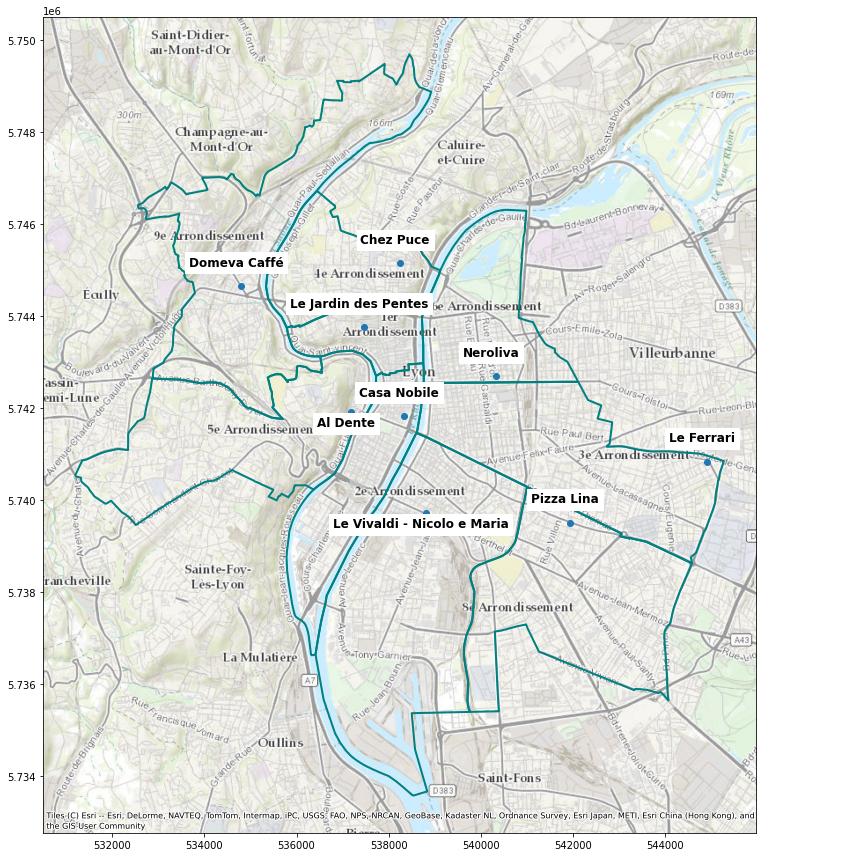

In [22]:
best_pizza = geopandas.GeoDataFrame(
    best_pizza,
    geometry = geopandas.points_from_xy(best_pizza['coordinates.longitude'], best_pizza['coordinates.latitude'],
    crs = 'EPSG:4326')
)

best_pizza.to_crs(str(lyon_map.crs), inplace = True)


ax = lyon_map.plot(edgecolor = "teal", facecolor = 'none', figsize=(15, 15), linewidth=2)
best_pizza.plot(ax = ax)
best_pizza.apply(lambda x: ax.annotate(text=x['name'],
                                     xy=x.geometry.centroid.coords[0],
                                     ha='center',
                                     xytext=(-5, -15) if x['location.zip_code'] in [69005, 69007] else (-5, 20),
                                     textcoords="offset points",
                                     weight = 'bold',
                                     fontsize = 12,
                                     backgroundcolor='1'), axis=1)

cx.add_basemap(ax, zoom = 13, crs = best_pizza.crs,
               source = cx.providers.Esri.WorldTopoMap);